In [8]:
import pandas as pd
import math
import gc
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import os
from itertools import combinations
import numpy as np
from random import seed, sample
import random
import numpy as np
from collections import Counter
import networkx as nx
import scipy.stats as stats
from scipy.stats import sem
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.decomposition import PCA

import hypernetx as hnx  # Hypergraph library
import itertools
from scipy.linalg import eigvalsh

#sys.path.append('/home/ll16598/Documents/Altered_States_Reddit/model_pipeline/__pycache__')
#from quality import reconst_qual, topic_diversity, coherence_centroid, coherence_pairwise #written for this jupyter notebook

In [9]:
test_mode=False
plot=False
if test_mode:
    save=False
else:
    save=True
print('TEST MODE')

threshold=244
# infile = open(f'/home/ll16598/Documents/POSTDOC/Context-DATM/sentenceBERT_cluster_dicts_{window}_{embedding_step}/cluster_dictionary_{save_thresh}','rb')
# cluster_dictionary=pickle.load(infile)
# infile.close()

user='luke'
if user=='luke':
    working_dir='/home/ll16598/Documents/POSTDOC/'
    dir_atom_dfs='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/final_dfs'
    dir_pp_dfs='/home/ll16598/Documents/POSTDOC/preprocessed_dfs'

    dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/vector_assigned_dfs'
elif user=='cluster':
    working_dir='/N/u/lleckie/Quartz/TDA/'
    dir_atom_dfs=working_dir+'/atom_assigned_dfs'

    dir_array=working_dir+'vector_assigned_dfs'

#df_drug=pd.read_csv(f'.{}/df_monolog_{threshold}.csv')


TEST MODE


In [10]:
df_monologs=pd.read_csv(f'{dir_atom_dfs}/SER_monologs.csv')
df_SER2=pd.read_csv(f'{dir_pp_dfs}/SER_IPSP.csv')
df_PEM=pd.read_csv(f'{dir_pp_dfs}/PEM_df.csv')
df_SER_MA=pd.read_csv(f'{dir_pp_dfs}/SER1.csv')
preprocessed_df_dir='/home/ll16598/Documents/POSTDOC/preprocessed_dfs'
df_MASM=pd.read_csv(preprocessed_df_dir + '/MASM.csv')
df_DEI=pd.read_csv(preprocessed_df_dir + '/cleaned_DEI.csv')

In [11]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
tokenizer = AutoTokenizer.from_pretrained("vblagoje/bert-english-uncased-finetuned-pos")
model = AutoModelForTokenClassification.from_pretrained("vblagoje/bert-english-uncased-finetuned-pos")

pos_tagger = pipeline("token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


Some weights of the model checkpoint at vblagoje/bert-english-uncased-finetuned-pos were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
import numpy as np
import pandas as pd
from collections import Counter
from scipy.stats import entropy
import ast

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def extract_words_by_category(text, categories, max_tokens=512):
    """
    Splits the text into manageable chunks, applies the POS tagger, and returns lemmatized words 
    that belong to the specified POS categories.
    
    Parameters:
      text (str): The input text.
      categories (tuple or list): The POS tags to extract (e.g., ("NOUN", "PROPN", "PRON")).
      max_tokens (int): Maximum token length for each chunk.
      
    Returns:
      list: A list of lemmatized words matching the desired categories.
    """
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    for sentence in sentences:
        tokenized_length = len(tokenizer(sentence, truncation=False)['input_ids'])
        if sum(len(tokenizer(s, truncation=False)['input_ids']) for s in current_chunk) + tokenized_length <= max_tokens:
            current_chunk.append(sentence)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]
    if current_chunk:
        chunks.append(" ".join(current_chunk))
        
    extracted_words = []
    for chunk in chunks:
        tags = pos_tagger(chunk)
        words = [lemmatizer.lemmatize(tag['word']) for tag in tags if tag['entity_group'] in categories]
        extracted_words.extend(words)
    return extracted_words

def calculate_word_entropy(word_list):
    """
    Calculates the normalized entropy of word occurrence frequencies.
    
    Parameters:
      word_list (list): List of words.
      
    Returns:
      float: Normalized entropy value.
    """
    if not word_list:
        return 0
    word_counts = Counter(word_list)
    frequencies = np.array(list(word_counts.values())) / len(word_list)
    return entropy(frequencies) / np.log(len(word_list))

def get_category_entropy(text, categories, max_tokens=512):
    """
    Extracts words by specified POS categories and returns their normalized entropy.
    
    Parameters:
      text (str): The input text.
      categories (tuple or list): POS tags to filter by.
      max_tokens (int): Maximum token length for chunking.
      
    Returns:
      float: Normalized entropy for the category.
    """
    words = extract_words_by_category(text, categories, max_tokens=max_tokens)
    return calculate_word_entropy(words)

def get_category_frequency(text, categories, max_tokens=512):
    """
    Extracts words by specified POS categories and returns the frequency distribution.
    
    Parameters:
      text (str): The input text.
      categories (tuple or list): POS tags to filter by.
      max_tokens (int): Maximum token length for chunking.
      
    Returns:
      Counter: Frequency distribution of words.
    """
    words = extract_words_by_category(text, categories, max_tokens=max_tokens)
    return Counter(words)

from collections import defaultdict
from statistics import mean

def get_avg_freq_and_gap(text):
    """
    1) Lemmatize and filter out stopwords + non-alphabetic tokens.
    2) Compute each word's frequency = count / total_non_stopwords.
    3) For any word that appears multiple times, compute the average gap 
       (# of words in between consecutive occurrences).
    4) Return two aggregated stats for the entire text:
         - The average of the relative frequencies (across all unique words).
         - The average gap across all repeated words.

    Returns: (avg_frequency, avg_gap)
    """
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())

    # Lemmatize and filter out stopwords/non-alphabetic tokens
    lemmatized_filtered = [
        lemmatizer.lemmatize(t) for t in tokens 
        if t.isalpha() and t not in stop_words
    ]
    
    # If no tokens remain after filtering, return (0, 0)
    if not lemmatized_filtered:
        return (0.0, 0.0)

    # Count positions of each word
    word_positions = defaultdict(list)
    for i, w in enumerate(lemmatized_filtered):
        word_positions[w].append(i)

    total_tokens = len(lemmatized_filtered)  # total non-stopword count
    unique_words = list(word_positions.keys())

    avg_freq = len(list(set(lemmatized_filtered))) / total_tokens
  #  avg_freq = np.mean(freqs)  # average of all words' relative frequencies

    repeated_gaps = []
    for positions in word_positions.values():
        if len(positions) > 1:
            # compute average gap for this repeated word
            gaps = []
            for i in range(len(positions) - 1):
                gap = positions[i+1] - positions[i] - 1
                gaps.append(gap)
            avg_gap_word = mean(gaps)
            repeated_gaps.append(avg_gap_word)

    if len(repeated_gaps) == 0:
        avg_gap = None  # or None, if you prefer
    else:
        avg_gap = mean(repeated_gaps)

    return (avg_freq, avg_gap)

from nltk.tokenize import word_tokenize

In [15]:
# 3) Define a helper function to transform a single row's embeddings
#dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors_large_model'
dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors'
dir_save='/home/ll16598/Documents/POSTDOC/PSYCH_SEMANTICS/word_count_results'
os.makedirs(dir_save, exist_ok=True)
import gc
import shutil
from tqdm import tqdm
tqdm.pandas()
def join_text(my_list):
    text= " ".join(my_list)
    return text

df_names=['SER_monologs', 'SER_IPSP', 'SER1', 'MASM', 'cleaned_DEI','PEM_df']
dfs1=[df_monologs,  df_SER2, df_SER_MA, df_MASM, df_DEI,df_PEM]

dfs=dfs1.copy()
for df_no, df_monolog in enumerate(dfs):
    df_name=df_names[df_no]

    with open(f'{dir_array}/utterance_{1}_{df_name}_utterances_X.pkl', 'rb') as f:
        sentences= pickle.load(f)
    if len(sentences)!=len(df_monolog):
        raise Exception('MISMATCH IN LENGTH')
    df_monolog['cleaned_utterances']=sentences
    df_monolog['cleaned_text']=df_monolog['cleaned_utterances'].apply(join_text)

    df_monolog['length'] = [len(i) for i in sentences]
    if test_mode:
        df_monolog=df_monolog[0:10]
    df_monolog = df_monolog[
        df_monolog["cleaned_utterances"].apply(
            lambda x: (
                not isinstance(x, float)               # exclude floats
                and isinstance(x, (list, tuple, np.ndarray))  # must be list/tuple/np.ndarray
                and len(x) >= 3                        # length >= 3
            )
        )]
#     print('computing entropies 1/3')
#     df_monolog['noun_entropy'] = df_monolog['cleaned_text'].progress_apply(lambda x: get_category_entropy(x, categories=("PRON", "NOUN", "PROPN")))
#     print('computing entropies 2/3')
#     df_monolog['adj_entropy'] = df_monolog['cleaned_text'].progress_apply(lambda x: get_category_entropy(x, categories=("ADJ",)))
#     print('computing entropies 3/3')
#     df_monolog['verb_entropy'] = df_monolog['cleaned_text'].progress_apply(lambda x: get_category_entropy(x, categories=("VERB",)))
#     print('computing frequencies 1/3')
#     df_monolog['noun_frequency'] = df_monolog['cleaned_text'].progress_apply(lambda x: get_category_frequency(x, categories=("PRON", "NOUN", "PROPN")))
#     print('computing frequencies 2/3')
#     df_monolog['adj_frequency'] = df_monolog['cleaned_text'].progress_apply(lambda x: get_category_frequency(x, categories=("ADJ",)))
#     print('computing frequencies 3/3')
#     df_monolog['verb_frequency'] = df_monolog['cleaned_text'].progress_apply(lambda x: get_category_frequency(x, categories=("VERB",)))
    print('computing reptitions')
    df_monolog['avg_freq_and_gap'] = df_monolog['cleaned_text'].progress_apply(get_avg_freq_and_gap)
    df_monolog[['avg_frequency', 'avg_gap']] = pd.DataFrame(
        df_monolog['avg_freq_and_gap'].tolist(), 
        index=df_monolog.index
    )
   # print(df_monolog['avg_frequency'])
    print('completed! ', df_name)
    df_monolog.to_csv(dir_save+f'/{df_name}_word_freq.csv')

computing reptitions


100%|█████████████████████████████████████████| 104/104 [00:02<00:00, 37.95it/s]


completed!  SER_monologs
computing reptitions


100%|█████████████████████████████████████████| 107/107 [00:04<00:00, 22.93it/s]


completed!  SER_IPSP
computing reptitions


100%|█████████████████████████████████████████| 108/108 [00:02<00:00, 43.67it/s]


completed!  SER1
computing reptitions


100%|███████████████████████████████████████████| 66/66 [00:02<00:00, 22.90it/s]


completed!  MASM
computing reptitions


100%|███████████████████████████████████████████| 73/73 [00:01<00:00, 44.24it/s]


completed!  cleaned_DEI
computing reptitions


100%|█████████████████████████████████████████| 130/130 [00:09<00:00, 13.58it/s]


completed!  PEM_df


Index(['Unnamed: 0', 'processed_text', 'Replicate', 'SubID', 'Session', 'Drug',
       'Participant', 'cleaned_utterances', 'cleaned_text', 'length',
       'noun_entropy', 'adj_entropy', 'verb_entropy', 'noun_frequency',
       'adj_frequency', 'verb_frequency', 'avg_freq_and_gap', 'avg_frequency',
       'avg_gap'],
      dtype='object')

In [50]:
def visualize_rips_simplicial_complex(embed, dataset_name, entry, max_edge_length=3):
    """
    1) Builds a Rips complex (via GUDHI) from a set of high-dimensional points.
    2) Extracts simplices (up to dimension 2) from the simplex tree.
       - Edges (1-simplices) and triangles (2-simplices).
    3) Uses PCA to reduce the points to 3D.
    4) Plots a 3D visualization:
       - Nodes are shown as a scatter plot.
       - Edges are drawn as lines.
       - Triangles are drawn as filled polygons (using Poly3DCollection).
    
    Parameters:
    -----------
    embed : np.ndarray of shape (N, D)
        The high-dimensional point cloud.
    max_edge_length : float
        The maximum edge length used in the Rips complex.
    """
    # 1) Build the Rips complex and create the simplex tree
    rips_complex = gd.RipsComplex(points=embed, max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=dims_simplex)
    
    # 2) Extract simplices:
    edges = []
    triangles = []
    
    # get_skeleton(2) returns all simplices up to dimension 2
    for simplex, fvalue in simplex_tree.get_skeleton(4):
        if len(simplex) == 2:
            # 1-simplices: edges
            edges.append(simplex)
        elif len(simplex) == 3:
            # 2-simplices: triangles
            triangles.append(simplex)
    # 3) Use PCA to reduce the point cloud to 3D
    pca = PCA(n_components=3)
    coords_3d = pca.fit_transform(embed)  # shape (N, 3)
    n_points = coords_3d.shape[0]
    
    # Prepare colormap for nodes (using 'magma_r')
    norm = plt.Normalize(vmin=0, vmax=n_points - 1)
    cmap = plt.get_cmap('plasma_r')
    node_colors = cmap(norm(np.arange(n_points)))
    
    # 4) Create the 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot nodes
    sc = ax.scatter(coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2],
                    c=node_colors, s=30, alpha=0.9)
    
    # Plot edges as lines
    for edge in edges:
        i, j = edge
        x_vals = [coords_3d[i, 0], coords_3d[j, 0]]
        y_vals = [coords_3d[i, 1], coords_3d[j, 1]]
        z_vals = [coords_3d[i, 2], coords_3d[j, 2]]
        # Optionally, color edge based on one endpoint's index or the average.
        avg_idx = int(np.mean(edge))
        edge_color = cmap(norm(avg_idx))
        ax.plot(x_vals, y_vals, z_vals, color=edge_color, alpha=0.8, linewidth=1.5)
    
    # Plot triangles as filled faces
    face_polys = []
    face_colors = []
    for tri in triangles:
        # Get the 3 vertices for this triangle
        pts = [coords_3d[idx] for idx in tri]
        face_polys.append(pts)
        # Color can be computed from the average index of the triangle's vertices
        avg_idx = int(np.mean(tri))
        face_colors.append(cmap(norm(avg_idx)))
    
    # Create a Poly3DCollection for the triangles with a set transparency (alpha)
    poly_collection = Poly3DCollection(face_polys, alpha=0.3, edgecolor='k')
    poly_collection.set_facecolor(face_colors)
    ax.add_collection3d(poly_collection)
    
    # Set title and labels
    ax.set_title(f"", pad=20)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_zlabel("PCA 3")
    
    # Add colorbar for node indices
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.1)
    cbar.set_label("Node Index")
        # Define three different viewing angles
    angles = [(15, 180), (30, 90), (45, 0)]  # (elevation, azimuth) in degrees
    dir_fig_save=working_dir+f'rips_skeletons/{dataset_name}_{window}_{step}/'
    os.makedirs(dir_fig_save, exist_ok=True)

    # Save figures from different angles
    for i, (elev, azim) in enumerate(angles):
        ax.view_init(elev=elev, azim=azim)  # Set camera angle
        filename = dir_fig_save+f"{entry}_{i}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save figure
       # print(f"Saved: {filename}")


In [73]:
# 3) Define a helper function to transform a single row's embeddings
#dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors_large_model'
import matplotlib.pyplot as plt
dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/window_vectors/'
dir_array_utt='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors'

pooling_method='mean'
if pooling_method=='max':
    ML=5
else:
    ML=3
    MLC=5
embeddings='sentence_embeddings'
reduce_dims=True
SPARSE=True
sparse_param=0.5
dims_simplex=3
chunk_size=2
step_sparsities=[0]
dim_reduction=50
span=1
window=60
step=int(0.25*window)
dfs=dfs1.copy()
df_monolog=df_monologs
df_name='SER_monologs'

with open(f'{dir_array}/{window}_{step}_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
    embeds= pickle.load(f)
    if pooling_method=='max':
        embeds=[np.array(i) for i in embeds]
        
with open(f'{dir_array_utt}/utterance_{span}_{df_name}_{pooling_method}_backX_sentence_embeddings_arrays.pkl', 'rb') as f:
    embeds2= pickle.load(f)
if len(embeds)!=len(df_monolog):
    raise Exception('MISMATCH IN LENGTH')

df_monolog['sentence_embeddings'] = embeds


<IPython.core.display.Javascript object>


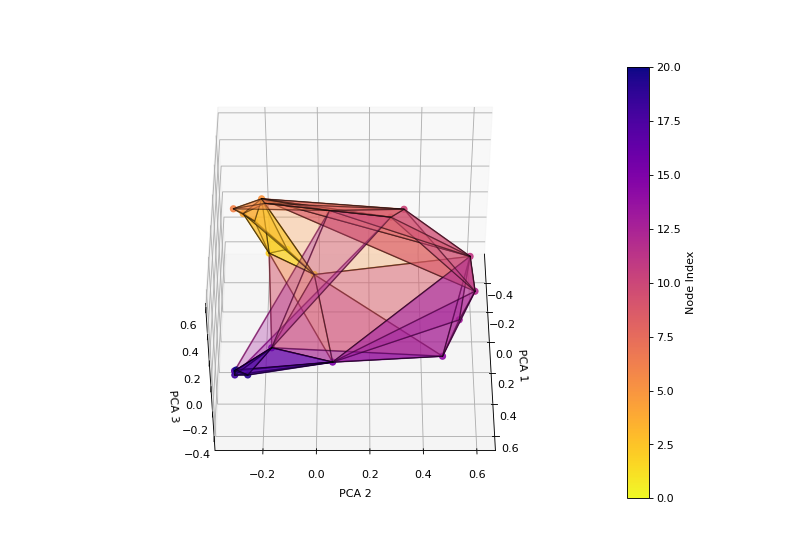

<IPython.core.display.Javascript object>


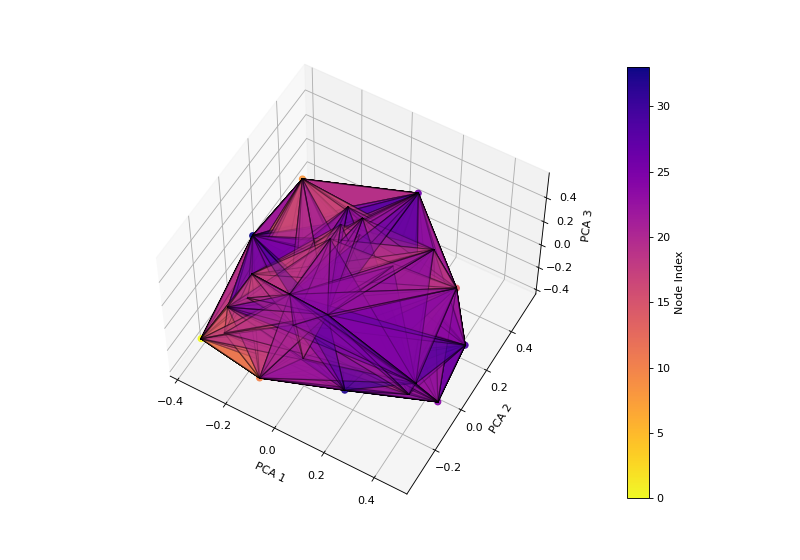

In [76]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib notebook
index=90
visualize_rips_simplicial_complex(embeds[index],'monolog',1,max_edge_length=1.1)
visualize_rips_simplicial_complex(embeds2[index],'monolog',1,max_edge_length=1.5)

In [ ]:
# 3) Define a helper function to transform a single row's embeddings
dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors'
pooling_method='mean'
if pooling_method=='max':
    ML=5
else:
    ML=3
    MLC=5
embeddings='sentence_embeddings'
reduce_dims=True
SPARSE=True
sparse_param=0.5
dims_simplex=3
chunk_size=2
step_sparsities=[0]

df_monologs=pd.read_csv(f'{dir_atom_dfs}/df_monolog_{threshold}.csv')
df_SER2=pd.read_csv(f'{dir_atom_dfs}/df_SER2_{threshold}.csv')
df_PEM=pd.read_csv(f'{dir_atom_dfs}/df_PEM.csv')
df_SER_MA=pd.read_csv(f'{dir_atom_dfs}/SER1.csv')
preprocessed_df_dir='/home/ll16598/Documents/POSTDOC/preprocessed_dfs'
df_MASM=pd.read_csv(preprocessed_df_dir + '/MASM.csv')
df_DEI=pd.read_csv(preprocessed_df_dir + '/cleaned_DEI.csv')

print(f'using {pooling_method} pooling')
import gc
import shutil
from tqdm import tqdm
df_names=['SER_monologs','PEM_df', 'SER_IPSP', 'SER1', 'MASM', 'cleaned_DEI']
dfs1=[df_monologs,df_PEM,  df_SER2, df_SER_MA, df_MASM, df_DEI]
if len(df_names)!=len(dfs1):
    raise Exception('MISMATCH IN NAMES/dfs') 
data_save_dir=working_dir+'TDA_output/'
os.makedirs(data_save_dir, exist_ok=True)

completed_files=os.listdir(data_save_dir)
dim_reduction=50
for ss, span in enumerate([4,5]):
    step_sparsity=0#step_sparsities[ss]
    print('Step size:', step_sparsity)
    layers='last'
    dfs=dfs1.copy()
    for df_no, df_monolog in enumerate(dfs):

        df_name=df_names[df_no]
#             if newfilename in completed_files:
#                 print(f'Already completed {newfilename}')
#                 continue
        data_save_dir_name=working_dir+f'TDA_output/{df_name}_{span}_{pooling_method}_{dim_reduction}/'
        if os.path.exists(data_save_dir_name):
            shutil.rmtree(data_save_dir_name)  # Deletes the entire directory and its contents
        os.makedirs(data_save_dir_name, exist_ok=True)

        with open(f'{dir_array}/utterance_{span}_{df_name}_{pooling_method}_back3_sentence_embeddings_arrays.pkl', 'rb') as f:
            embeds= pickle.load(f)
            if pooling_method=='max':
                embeds=[np.array(i) for i in embeds]
        newfilename=f'{df_name}_utterance_distance_results_{dim_reduction}.csv'
        if len(embeds)!=len(df_monolog):
            raise Exception('MISMATCH IN LENGTH')

        df_monolog['sentence_embeddings'] = embeds


        print(len(embeds))
        print(len(df_monolog))
        if len(embeds)!=len(df_monolog):
            raise Exception('MISMATCH IN LENGTH')

        df_monolog['sentence_embeddings'] = embeds
        df_monolog['length'] = [len(i) for i in embeds]
        if test_mode:
            df_monolog=df_monolog[0:10]
        df_monolog = df_monolog[
            df_monolog["sentence_embeddings"].apply(
                lambda x: (
                    not isinstance(x, float)               # exclude floats
                    and isinstance(x, (list, tuple, np.ndarray))  # must be list/tuple/np.ndarray
                    and len(x) >= 3                        # length >= 3
                )
            )]

        # 4) Apply that function to each row -> produce a new column
        if reduce_dims:
            print('reducing dims')
            all_vecs = []
            for row in df_monolog['sentence_embeddings']:
                arr = np.array(row)  
                all_vecs.append(arr)
            big_matrix = np.concatenate(all_vecs, axis=0)
            pca = PCA(n_components=dim_reduction, svd_solver='full')
            pca.fit(big_matrix)
            def transform_embeddings(emb_list):
                emb_array = np.array(emb_list)   # shape (k_i, 384)
                emb_pca = pca.transform(emb_array)  # shape (k_i, 50)
                return emb_pca
            df_monolog['sentence_embeddings'] = df_monolog['sentence_embeddings'].apply(transform_embeddings)
          #  print(df_monolog['sentence_embeddings'].iloc[0])
            #         df_monolog['sentence_embeddings'] = df_monolog['sentence_embeddings'].apply(
#             lambda x: increase_sparsity(x, skip=step_sparsity)
#         )
        df_monolog['token_embeddings']=None
        print('performing TDA on ',df_name, ' span: ', span)#, 'step: ', step)

        for fi in tqdm(range(0, len(df_monolog), chunk_size), desc="Processing Chunks"):
            if fi+chunk_size>=len(df_monolog):
                df_subset=df_monolog[fi:].reset_index(drop=True)
            else:
                df_subset=df_monolog[fi:fi+chunk_size].reset_index(drop=True)


           # drugs=list(set(df_subset['Drug']))
            #Participants=list(set(df_subset['Participant']))
            df_subset=get_rips_time(df_subset,embeddings=embeddings)
           # df_subset=get_rips_time_centroid(df_subset,embeddings=embeddings)
            #df_monolog=get_simplices_over_time(df_monolog,simplex_tree_type='simplex_tree')
            #print('got RIPS')
            df_with_graph=get_rips_complex_G(df_subset)
            #print('got G')
            #df_with_graph['euler'] = df_with_graph['rt_simplex_tree'].apply(lambda st: compute_euler_characteristic(st, max_dim=4))
            # Apply the function to each graph in df_with_graph
            graph_metrics = df_with_graph['graph'].apply(compute_graph_metrics)
            graph_metrics_df = pd.DataFrame(graph_metrics.tolist())
            df_with_graph = pd.concat([df_with_graph, graph_metrics_df], axis=1)
                        # Create a new DataFrame

            # We'll accumulate new rows in a list of dicts
            new_rows = []
            dimensions = [0, 1, 2]

            for idx, row in df_with_graph.iterrows():
                embed = row[embeddings]  # Adjust as needed
                # We’ll store births, deaths, pers LENGTHS in a dict keyed by dimension
                dim_dict = {
                    dim: {'births': [], 'deaths': [], 'pers': []}
                    for dim in dimensions
                }



                # Build the Rips Complex for *this row only*
                rips_complex =row['rips']
                try:
                    simplex_tree = \
                    rips_complex.create_simplex_tree(max_dimension=dims_simplex)
                except Exception as e:
                    continue
                persistence = simplex_tree.persistence()

                # Collect intervals by dimension
                for dim, (b, d) in persistence:
                    if d == float('inf'):
                        continue
                    if dim in dimensions:
                        dim_dict[dim]['births'].append(b)
                        dim_dict[dim]['deaths'].append(d)
                        dim_dict[dim]['pers'].append(d - b)


                row_dict = row.to_dict()  # Start with original row's columns

                for dim in dimensions:
                    bdp = dim_dict[dim]
                    stats_dict = compute_distribution_stats(bdp['births'], bdp['deaths'], bdp['pers'])
                    # prefix each stat key with dim
                    for stat_key, stat_val in stats_dict.items():
                        row_dict[f"{stat_key}_dim{dim}"] = stat_val

                # Add row_dict to new_rows
                new_rows.append(row_dict)

            # Create a new DataFrame
            df_with_tda = pd.DataFrame(new_rows)
            df_with_tda.to_csv(data_save_dir_name + f'{df_name}_{fi}_{span}_TDA_results.csv')
            del df_subset
            del df_with_graph
            gc.collect()
        print(f'completed! {df_name} span: {span}')
        list_files=sorted(os.listdir(data_save_dir_name))
        ddfs=[]
        for f in list_files:
            ddfs.append(pd.read_csv(data_save_dir_name+f))
        data=pd.concat(ddfs)
        data.to_csv(data_save_dir+f'{df_name}_{span}_{pooling_method}_{dim_reduction}_utterance_TDA_results.csv')

In [ ]:
for SP in [1,2,3]:
    for name in ['PEM_df','SER_IPSP','SER_monologs','MASM', 'cleaned_DEI']:
        data_save_dir=working_dir+'TDA_output/'
        data_save_dir_name=working_dir+f'TDA_output/{name}_{SP}_mean/'
        list_files=sorted(os.listdir(data_save_dir_name))
        dfs=[]
        for f in list_files:
            dfs.append(pd.read_csv(data_save_dir_name+f))
        data=pd.concat(dfs)
        data.to_csv(data_save_dir+f'{name}_{SP}_back_utterance_TDA_results.csv')
        print(name, len(data))

In [ ]:
# 3) Define a helper function to transform a single row's embeddings
ML=3
embeddings='sentence_embeddings'
reduce_dims=True
SPARSE=True
sparse_param=0.5
dims_simplex=3
chunk_size=5
df_monologs=pd.read_csv(f'{dir_atom_dfs}/df_monolog_{threshold}.csv')
df_SER2=pd.read_csv(f'{dir_atom_dfs}/df_SER2_{threshold}.csv')
df_PEM=pd.read_csv(f'{dir_atom_dfs}/df_PEM.csv')
df_SER_MA=pd.read_csv(f'{dir_atom_dfs}/SER1.csv')


In [5]:
import gc
import shutil
df_names=['PEM_df','SER_monologs', 'SER_IPSP', 'SER1']
data_save_dir=working_dir+'TDA_output/'
os.makedirs(data_save_dir, exist_ok=True)

completed_files=os.listdir(data_save_dir)
# for overlap in [0.1,0.2,0.4]:
#     for window in [60,80,100,120,140,160,180,200]:

# for overlap in [0.1,0.2,0.4]:
#     for window in [60,80,100,120,140,160,180,200]:
        
for overlap in [0.1]:
    for window in ['utterances']:
        layers='last'

        dfs=[df_PEM, df_monologs, df_SER2, df_SER_MA]

        for df_no, df_monolog in enumerate(dfs):

            df_name=df_names[df_no]
#             if newfilename in completed_files:
#                 print(f'Already completed {newfilename}')
#                 continue
            data_save_dir_name=working_dir+f'TDA_output/{df_name}/'
            if os.path.exists(data_save_dir_name):
                shutil.rmtree(data_save_dir_name) 
            os.makedirs(data_save_dir_name, exist_ok=True)

            if window=='utterances':
                with open(f'{dir_array}/utterance_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
                    embeds= pickle.load(f)   
                newfilename=f'{df_name}_utterance_distance_results.csv'

            else:
                step=int(window*overlap)#4
                with open(f'{dir_array}/{window}_{step}_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
                    embeds = pickle.load(f)   
                newfilename=f'{df_name}_{window}_{step}_distance_results.csv'
            
            if len(embeds)!=len(df_monolog):
                raise Exception('MISMATCH IN LENGTH')
                
            df_monolog['sentence_embeddings'] = embeds


            print(len(embeds))
            print(len(df_monolog))
            if len(embeds)!=len(df_monolog):
                raise Exception('MISMATCH IN LENGTH')

            df_monolog['sentence_embeddings'] = embeds
            df_monolog['length'] = [len(i) for i in embeds]
            if test_mode:
                df_monolog=df_monolog[0:10]
            df_monolog = df_monolog[
                df_monolog["sentence_embeddings"].apply(
                    lambda x: (
                        not isinstance(x, float)               # exclude floats
                        and isinstance(x, (list, tuple, np.ndarray))  # must be list/tuple/np.ndarray
                        and len(x) >= 3                        # length >= 3
                    )
                )]

            # 4) Apply that function to each row -> produce a new column
            if reduce_dims:
                all_vecs = []
                for row in df_monolog['sentence_embeddings']:
                    arr = np.array(row)  
                    all_vecs.append(arr)
                big_matrix = np.concatenate(all_vecs, axis=0)
                pca = PCA(n_components=50)
                pca.fit(big_matrix)
                def transform_embeddings(emb_list):
                    emb_array = np.array(emb_list)   # shape (k_i, 384)
                    emb_pca = pca.transform(emb_array)  # shape (k_i, 50)
                    return emb_pca
                df_monolog['sentence_embeddings'] = df_monolog['sentence_embeddings'].apply(transform_embeddings)
            df_monolog['token_embeddings']=None
            print('performing TDA on ',df_name, ' window: ', window)#, 'step: ', step)
            
            for fi in range(0, len(df_monolog), chunk_size):
                
                if fi+chunk_size>=len(df_monolog):
                    df_subset=df_monolog[fi:].reset_index(drop=True)
                else:
                    df_subset=df_monolog[fi:fi+chunk_size].reset_index(drop=True)
                

                drugs=list(set(df_subset['Drug']))
                #Participants=list(set(df_subset['Participant']))
                df_subset=get_rips_time(df_subset,embeddings=embeddings)
               # df_subset=get_rips_time_centroid(df_subset,embeddings=embeddings)
                #df_monolog=get_simplices_over_time(df_monolog,simplex_tree_type='simplex_tree')
                print('got RIPS')
                df_with_graph=get_rips_complex_G(df_subset)
                print('got G')
                print(df_with_graph['graph'][0].nodes())
                #df_with_graph['euler'] = df_with_graph['rt_simplex_tree'].apply(lambda st: compute_euler_characteristic(st, max_dim=4))
                # Apply the function to each graph in df_with_graph
                graph_metrics = df_with_graph['graph'].apply(compute_graph_metrics)

                print(graph_metrics)
                graph_metrics_df = pd.DataFrame(graph_metrics.tolist())
                df_with_graph = pd.concat([df_with_graph, graph_metrics_df], axis=1)
                            # Create a new DataFrame

                # We'll accumulate new rows in a list of dicts
                new_rows = []
                dimensions = [0, 1, 2]

                for idx, row in df_with_graph.iterrows():
                    embed = row[embeddings]  # Adjust as needed
                    # We’ll store births, deaths, pers LENGTHS in a dict keyed by dimension
                    dim_dict = {
                        dim: {'births': [], 'deaths': [], 'pers': []}
                        for dim in dimensions
                    }



                    # Build the Rips Complex for *this row only*
                    rips_complex =row['rips']
                    try:
                        simplex_tree = \
                        rips_complex.create_simplex_tree(max_dimension=dims_simplex)
                    except Exception as e:
                        continue
                    persistence = simplex_tree.persistence()

                    # Collect intervals by dimension
                    for dim, (b, d) in persistence:
                        if d == float('inf'):
                            continue
                        if dim in dimensions:
                            dim_dict[dim]['births'].append(b)
                            dim_dict[dim]['deaths'].append(d)
                            dim_dict[dim]['pers'].append(d - b)


                    row_dict = row.to_dict()  # Start with original row's columns

                    for dim in dimensions:
                        bdp = dim_dict[dim]
                        stats_dict = compute_distribution_stats(bdp['births'], bdp['deaths'], bdp['pers'])
                        # prefix each stat key with dim
                        for stat_key, stat_val in stats_dict.items():
                            row_dict[f"{stat_key}_dim{dim}"] = stat_val

                    # Add row_dict to new_rows
                    new_rows.append(row_dict)

                # Create a new DataFrame
                df_with_tda = pd.DataFrame(new_rows)
                if window=='utterances':
                    df_with_tda.to_csv(data_save_dir_name + f'{df_name}_{fi}_{window}_TDA_results.csv')
                else:
                    df_with_tda.to_csv(data_save_dir_name + f'{df_name}_{fi}_{window}_{step}_TDA_results.csv')
                print(f'completed! {df_name} window: {window}')
                del df_subset
                del df_with_graph
                gc.collect()

130
130
performing TDA on  PEM_df  window:  utterances
rips mem 0 285.8203125
simplex mem 346.5078125
persistence mem 402.87109375
rips max mem 402.87109375
rips mem 1 402.87109375
simplex mem 432.5625
persistence mem 432.5625
rips max mem 432.5625
rips mem 2 432.5625
simplex mem 432.5625
persistence mem 432.5625
rips max mem 432.5625
rips mem 3 432.5625
simplex mem 432.5625
persistence mem 432.5625
rips max mem 432.5625
rips mem 4 432.5625
simplex mem 432.5625
persistence mem 432.5625
rips max mem 432.5625
got RIPS
got G
[0, 5, 7, 8, 18, 23, 28, 38, 39, 76, 43, 24, 37, 67, 55, 59, 66, 40, 58, 44, 77, 1, 2, 3, 4, 13, 27, 30, 31, 53, 60, 19, 61, 62, 63, 26, 68, 75, 33, 57, 29, 36, 71, 11, 12, 20, 21, 22, 64, 14, 10, 52, 25, 16, 46, 47, 81, 65, 17, 32, 35, 9, 56, 80, 42, 15, 69, 48, 70, 45, 54, 6, 78, 34, 72, 73, 74, 49, 51, 41, 79, 50]
0    {'shortest_path_unweighted': 2, 'nodes': 82, '...
1    {'shortest_path_unweighted': 2, 'nodes': 75, '...
2    {'shortest_path_unweighted': 1, 'nodes

persistence mem 654.16015625
rips max mem 654.16015625
rips mem 2 654.16015625
simplex mem 654.16015625
persistence mem 654.14453125
rips max mem 654.14453125
rips mem 3 654.14453125
simplex mem 654.14453125
persistence mem 654.14453125
rips max mem 654.14453125
rips mem 4 654.14453125
simplex mem 654.14453125
persistence mem 654.14453125
rips max mem 654.14453125
got RIPS
got G
[0, 4, 22, 23, 26, 27, 28, 30, 33, 37, 49, 53, 58, 59, 62, 66, 69, 75, 43, 79, 73, 52, 77, 32, 78, 1, 2, 3, 7, 9, 11, 18, 20, 21, 44, 45, 50, 57, 63, 64, 65, 68, 76, 46, 17, 13, 51, 6, 12, 16, 55, 56, 61, 72, 47, 54, 71, 81, 15, 14, 74, 60, 67, 70, 82, 80, 42, 19, 29, 5, 38, 10, 34, 31, 36, 8, 35, 48, 24, 39, 41, 40]
0    {'shortest_path_unweighted': 2, 'nodes': 82, '...
1    {'shortest_path_unweighted': 2, 'nodes': 68, '...
2    {'shortest_path_unweighted': 1, 'nodes': 89, '...
3    {'shortest_path_unweighted': 2, 'nodes': 17, '...
4    {'shortest_path_unweighted': 1, 'nodes': 59, '...
Name: graph, dtype: obje

KeyboardInterrupt: 

using max pooling


130
130
performing TDA on  PEM_df  span:  1


Processing Chunks:   0%|                                 | 0/26 [00:00<?, ?it/s]


TypeError: must be real number, not NoneType

In [11]:
SP=2
for name in ['PEM_df','SER_IPSP','SER_monologs','MASM', 'cleaned_DEI']:
    data_save_dir=working_dir+'TDA_output/'
    data_save_dir_name=working_dir+f'TDA_output/{name}_{SP}/'
    list_files=sorted(os.listdir(data_save_dir_name))
    dfs=[]
    for f in list_files:
        dfs.append(pd.read_csv(data_save_dir_name+f))
    data=pd.concat(dfs)
    data.to_csv(data_save_dir+f'{name}_{SP}_back_utterance_TDA_results.csv')
    print(name, len(data))

PEM_df 130
SER_IPSP 107
SER_monologs 100
MASM 66
cleaned_DEI 73


In [29]:
df_names=['PEM_df','SER_monologs', 'SER_IPSP', 'SER1', 'MASM', 'cleaned_DEI']
    data_save_dir=working_dir+'TDA_output/'
    data_save_dir_name=working_dir+f'TDA_output/{name}_{1}/'
    list_files=sorted(os.listdir(data_save_dir_name))
    dfs=[]
    for f in list_files:
        dfs.append(pd.read_csv(data_save_dir_name+f))
    data=pd.concat(dfs)
    data.to_csv(data_save_dir+f'{name}_{1}_utterance_TDA_results.csv')

PEM_df 130
SER_IPSP 107
SER_monologs 100
MASM 66
cleaned_DEI 73


In [29]:
for name in ['PEM_df','SER_monologs', 'SER_IPSP', 'SER1']:
    data_save_dir=working_dir+'TDA_output/'
    data_save_dir_name=working_dir+f'TDA_output/{name}/'
    list_files=sorted(os.listdir(data_save_dir_name))
    dfs=[]
    for f in list_files:
        dfs.append(pd.read_csv(data_save_dir_name+f))
    data=pd.concat(dfs)
    data.to_csv(data_save_dir+f'{name}_utterances_TDA_results.csv')

In [16]:
data_save_dir

'/home/ll16598/Documents/POSTDOC/TDA_output/'

In [ ]:
data_save_dir_name=working_dir+f'TDA_output/{df_name}/'
os.makedirs(data_save_dir_name, exist_ok=True)

df_monolog['token_embeddings']=None
print('performing TDA on ',df_name, ' window: ', window, 'step: ', step)

for fi in range(0, len(df_monolog), chunk_size):

    if fi+chunk_size>=len(df_monolog):
        df_subset=df_monolog[fi:]
    else:
        df_subset=df_monolog[fi:fi+chunk_size]

    df_subset=get_rips_time(df_subset,embeddings=embeddings)
    df_subset=get_rips_time_centroid(df_subset,embeddings=embeddings)
    print('completed rips')
    df_subset=get_simplices_over_time(df_subset,simplex_tree_type='simplex_tree')
    for D in [2, 3, 4]:
        # Explode the lists in the columns for the current dimension.
        try:
            df_exploded = df_subset.explode([f"simplex_time_dim{D}_filtration", f"simplex_time_dim{D}_count"])
        except Exception as e:
            continue
       # Convert the exploded columns to numeric.
        df_exploded[f"simplex_time_dim{D}_filtration"] = pd.to_numeric(df_exploded[f"simplex_time_dim{D}_filtration"])
        df_exploded[f"simplex_time_dim{D}_count"] = pd.to_numeric(df_exploded[f"simplex_time_dim{D}_count"])

        # Group by "Drug" and the filtration values, and compute the mean and standard error for the counts.
        grouped = df_exploded.groupby(["Drug", f"simplex_time_dim{D}_filtration"], as_index=False).agg(
            alive_mean=(f"simplex_time_dim{D}_count", "mean"),
            alive_se=(f"simplex_time_dim{D}_count", sem)  # standard error
        )
        if save:
            df_exploded.to_csv(data_save_dir_name + f'{fi}_{df_name}_{window}_{step}_{D}_skeleton_simplices_over_time.csv', index=False)


        if plot:
            import matplotlib.pyplot as plt
            # Create a plot for the current dimension.
            fig, ax = plt.subplots(figsize=(8, 6))

            # Iterate over each drug group and plot mean ± SE.
            for drug_level, df_sub in grouped.groupby("Drug"):
                ax.errorbar(
                    df_sub[f"simplex_time_dim{D}_filtration"],
                    df_sub["alive_mean"],
                    yerr=df_sub["alive_se"],
                    label=f"Drug={drug_level}",
                    marker='o',
                    capsize=3
                )

            ax.set_xlabel("Filtration Value (Distance Threshold)")
            ax.set_ylabel("Number of Alive Components (Mean ± SE)")
            ax.set_title(f"Dimension {D} Alive Components Over Filtration Value by Drug")
            ax.legend()
            plt.show()

    for D in [0,1,2]:
        df_exploded = df_subset.explode([f"scales_dim{D}", f'alive_dim{D}'])
        df_exploded[f"scales_dim{D}"] = pd.to_numeric(df_exploded[f"scales_dim{D}"])
        df_exploded[f'alive_dim{D}'] = pd.to_numeric(df_exploded[f'alive_dim{D}'])
        grouped = df_exploded.groupby(["Drug", f"scales_dim{D}"], as_index=False).agg(
            alive_mean=(f'alive_dim{D}', "mean"),
            alive_se=(f'alive_dim{D}', sem)  # standard error
        )
        df_exploded.to_csv(data_save_dir_name+f'{fi}_{df_name}_{window}_{step}_{D}_simplices_over_time.csv')
        if plot:

            fig, ax = plt.subplots(figsize=(8,6))

            # We'll iterate over each drug and plot mean ± SE
            for drug_level, df_sub in grouped.groupby("Drug"):
                ax.errorbar(
                    df_sub[f"scales_dim{D}"], 
                    df_sub["alive_mean"], 
                    yerr=df_sub["alive_se"], 
                    label=f"Drug={drug_level}",
                    marker='o',
                    capsize=3
                )

            ax.set_xlabel("Scale (distance threshold)")
            ax.set_ylabel("Number of Alive Components (Mean ± SE)")
            ax.set_title("Connected Components Over Scale by Drug")
            ax.legend()
            plt.show()

    df_with_graph=get_rips_complex_G(df_subset)
    #df_with_graph['euler'] = df_with_graph['rt_rips'].apply(lambda st: compute_euler_characteristic(st, max_dim=4))
    # Apply the function to each graph in df_with_graph
    graph_metrics = df_with_graph['graph'].apply(compute_graph_metrics)
    graph_metrics_df = pd.DataFrame(graph_metrics.tolist())
    df_with_graph = pd.concat([df_with_graph, graph_metrics_df], axis=1)



    dimensions = [0, 1, 2]

    # We'll accumulate new rows in a list of dicts
    new_rows = []

    for idx, row in df_subset.iterrows():
        embed = row[embeddings]  # Adjust as needed
        # We’ll store births, deaths, pers LENGTHS in a dict keyed by dimension
        dim_dict = {
            dim: {'births': [], 'deaths': [], 'pers': []}
            for dim in dimensions
        }



        # Build the Rips Complex for *this row only*
        rips_complex =row['rips']
        try:
            simplex_tree = rips_complex.create_simplex_tree(max_dimension=dims_simplex)
        except Exception as e:
            continue
        persistence = simplex_tree.persistence()

        # Collect intervals by dimension
        for dim, (b, d) in persistence:
            if d == float('inf'):
                continue
            if dim in dimensions:
                dim_dict[dim]['births'].append(b)
                dim_dict[dim]['deaths'].append(d)
                dim_dict[dim]['pers'].append(d - b)


        row_dict = row.to_dict()  # Start with original row's columns

        for dim in dimensions:
            bdp = dim_dict[dim]
            stats_dict = compute_distribution_stats(bdp['births'], bdp['deaths'], bdp['pers'])
            # prefix each stat key with dim
            for stat_key, stat_val in stats_dict.items():
                row_dict[f"{stat_key}_dim{dim}"] = stat_val

        # Add row_dict to new_rows
        new_rows.append(row_dict)

    # Create a new DataFrame
    print('completed',f'{df_name}_{window}_{step}')
    df_with_tda = pd.DataFrame(new_rows)
    if reduce_dims:
        df_with_tda.to_csv(data_save_dir_name + f'{fi}_D50_{SP}{df_name}_{window}_{step}_TDA_results.csv')
    else:
        df_with_tda.to_csv(data_save_dir_name + f'{fi}_{SP}{df_name}_{window}_{step}_TDA_results.csv')
    print(f'completed! {df_name} window: {window} step size: {step}')

In [ ]:

df_names=['SER_monologs', 'PEM_df', 'SER_IPSP', 'SER1']
data_save_dir=working_dir+'TDA_output/'
os.makedirs(data_save_dir, exist_ok=True)

completed_files=os.listdir(data_save_dir)
# for overlap in [0.1,0.2,0.4]:
#     for window in [60,80,100,120,140,160,180,200]:

# for overlap in [0.1,0.2,0.4]:
#     for window in [60,80,100,120,140,160,180,200]:
        
for overlap in [0.1]:
    for window in [100]:
        step=int(window*overlap)#4
        layers='last'

        dfs=[df_monologs, df_PEM, df_SER2, df_SER_MA]

        for df_no, df_monolog in enumerate(dfs):

            df_name=df_names[df_no]
            newfilename=f'{df_name}_{window}_{step}_TDA_results.csv'
#             if newfilename in completed_files:
#                 print(f'Already completed {newfilename}')
#                 continue
        
            with open(f'{dir_array}/{window}_{step}_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
                embeds = pickle.load(f)
            
            df_monolog['sentence_embeddings'] = embeds


            print(len(embeds))
            print(len(df_monolog))
            if len(embeds)!=len(df_monolog):
                raise Exception('MISMATCH IN LENGTH')

            df_monolog['sentence_embeddings'] = embeds
            df_monolog['length'] = [len(i) for i in embeds]
            if test_mode:
                df_monolog=df_monolog[0:10]
            df_monolog = df_monolog[
                df_monolog["sentence_embeddings"].apply(
                    lambda x: (
                        not isinstance(x, float)               # exclude floats
                        and isinstance(x, (list, tuple, np.ndarray))  # must be list/tuple/np.ndarray
                        and len(x) >= 3                        # length >= 3
                    )
                )]

            # 4) Apply that function to each row -> produce a new column
            if reduce_dims:
                all_vecs = []
                for row in df_monolog['sentence_embeddings']:
                    arr = np.array(row)  
                    all_vecs.append(arr)
                big_matrix = np.concatenate(all_vecs, axis=0)
                pca = PCA(n_components=50)
                pca.fit(big_matrix)
                def transform_embeddings(emb_list):
                    emb_array = np.array(emb_list)   # shape (k_i, 384)
                    emb_pca = pca.transform(emb_array)  # shape (k_i, 50)
                    return emb_pca
                df_monolog['sentence_embeddings'] = df_monolog['sentence_embeddings'].apply(transform_embeddings)
            df_monolog['token_embeddings']=None
            print('performing TDA on ',df_name, ' window: ', window, 'step: ', step)

            for fi in range(0, len(df_monolog), chunk_size):
                
                if fi+chunk_size>=len(df_monolog):
                    df_subset=df_monolog[fi:]
                else:
                    df_subset=df_monolog[fi:fi+chunk_size]
                

                drugs=list(set(df_subset['Drug']))
                Participants=list(set(df_subset['Participant']))
                df_subset=get_rips_time(df_subset,embeddings=embeddings)
               # df_subset=get_rips_time_centroid(df_subset,embeddings=embeddings)
                #df_monolog=get_simplices_over_time(df_monolog,simplex_tree_type='simplex_tree')

                df_with_graph=get_rips_complex_G(df_subset)
                df_with_graph['euler'] = df_with_graph['rt_simplex_tree'].apply(lambda st: compute_euler_characteristic(st, max_dim=4))
                # Apply the function to each graph in df_with_graph
                graph_metrics = df_with_graph['graph'].apply(compute_graph_metrics)
                print(graph_metrics)
                graph_metrics_df = pd.DataFrame(graph_metrics.tolist())
                df_with_graph = pd.concat([df_with_graph, graph_metrics_df], axis=1)
                            # Create a new DataFrame
                df_with_graph.to_csv(data_save_dir + f'{df_name}_{fi}_{window}_{step}_TDA_results.csv')
                df_subset=None
                df_with_graph=None
                print(f'completed! {df_name} window: {window} step size: {step}')

In [ ]:
def get_rips_time(df, embeddings='sentence_embeddings', step=0.025):
    """
    For each row in df, build a Rips complex, extract dimension-D intervals
    (e.g., D=0 => connected components, D=1 => loops, etc.),
    then compute how many such features are 'alive' at increments of 'step'.

    Creates two new columns in df:
    - f"scales_dim{D}": The scale values
    - f"alive_dim{D}": The counts of alive features at each scale
    """
    # Copy the DataFrame to avoid SettingWithCopy warnings
    df = df.copy()
    
    # Prepare two new columns (lists)
    df[f'scales_dim0'] = None
    df[f'alive_dim0'] = None
    df[f'scales_dim1'] = None
    df[f'alive_dim1'] = None
    df[f'scales_dim2'] = None
    df[f'alive_dim2'] = None
    df['rt'] = None
    df['simplex_tree']=None
    df["rt_rips"]=None
    
    for idx, row in df.iterrows():
        # Get the embeddings for this row
        embed = row[embeddings]
        if not isinstance(embed, (list, np.ndarray)) or len(embed) == 0:
            continue
        
        # Build the Rips Complex
        rips_complex = gd.RipsComplex(points=embed, max_edge_length=3)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=dims_simplex)

        # Extract dimension-D intervals from persistence
        persistence = simplex_tree.persistence()
        for D in [0,1,2]:
            births_dimD = []
            deaths_dimD = []

            for dim, (b, d) in persistence:
                if dim == D and d != float('inf'):  # ignoring infinite intervals
                    births_dimD.append(b)
                    deaths_dimD.append(d)

            # Compute how many features are alive at each scale
            scales, alive_components = get_alive_components_over_scales(births_dimD, deaths_dimD, step=step)
            if len(deaths_dimD)>0:
                df.at[idx, f"rt"] = max(deaths_dimD)

            # Store these lists in the new columns
            df.at[idx, f"scales_dim{D}"] = scales
            df.at[idx, f"alive_dim{D}"] = alive_components
        try:
            rips_complex_max = gd.RipsComplex(points=embed, max_edge_length=df["rt"].loc[idx])
        except Exception as e:
            print(idx, df["rt"].loc[idx], embed)
        simplex_tree_max = rips_complex.create_simplex_tree(max_dimension=dims_simplex)
        df.at[idx, f"simplex_tree"] = simplex_tree
        df.at[idx, f"rt_simplex_tree"] = simplex_tree_max
        df.at[idx, f"rt_rips"] = rips_complex_max

    return df

In [ ]:
def visualize_rips_simplicial_complex(rt_rips, simp_tree, dataset_name, entry, max_edge_length=5.0,SAVE=False):
    """
    1) Builds a Rips complex (via GUDHI) from a set of high-dimensional points.
    2) Extracts simplices (up to dimension 2) from the simplex tree.
       - Edges (1-simplices) and triangles (2-simplices).
    3) Uses PCA to reduce the points to 3D.
    4) Plots a 3D visualization:
       - Nodes are shown as a scatter plot.
       - Edges are drawn as lines.
       - Triangles are drawn as filled polygons (using Poly3DCollection).
    
    Parameters:
    -----------
    embed : np.ndarray of shape (N, D)
        The high-dimensional point cloud.
    max_edge_length : float
        The maximum edge length used in the Rips complex.
    """
#     # 1) Build the Rips complex and create the simplex tree
#     rips_complex = gd.RipsComplex(points=embed, max_edge_length=max_edge_length)
    simplex_tree = rt_rips.create_simplex_tree(max_dimension=5)
    
#     # 2) Extract simplices:
    edges = []
    triangles = []
    
    # get_skeleton(2) returns all simplices up to dimension 2
    for simplex, fvalue in simplex_tree.get_skeleton(4):
        if len(simplex) == 2:
            # 1-simplices: edges
            edges.append(simplex)
        elif len(simplex) == 3:
            # 2-simplices: triangles
            triangles.append(simplex)
    G=nx.Graph()        
    for simplex, fvalue in simplex_tree.get_skeleton(4):
        if len(simplex) >= 2:
            for (i, j) in itertools.combinations(simplex, 2):
                G.add_edge(i, j, weight=fvalue)
    metrics=compute_graph_metrics(G)
    print(metrics)
    # 3) Use PCA to reduce the point cloud to 3D
    pca = PCA(n_components=3)
    coords_3d = pca.fit_transform(embed)  # shape (N, 3)
    n_points = coords_3d.shape[0]
    
    # Prepare colormap for nodes (using 'magma_r')
    norm = plt.Normalize(vmin=0, vmax=n_points - 1)
    cmap = plt.get_cmap('plasma_r')
    node_colors = cmap(norm(np.arange(n_points)))
    
    # 4) Create the 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot nodes
    sc = ax.scatter(coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2],
                    c=node_colors, s=30, alpha=0.9)
    
    # Plot edges as lines
    for edge in edges:
        i, j = edge
        x_vals = [coords_3d[i, 0], coords_3d[j, 0]]
        y_vals = [coords_3d[i, 1], coords_3d[j, 1]]
        z_vals = [coords_3d[i, 2], coords_3d[j, 2]]
        # Optionally, color edge based on one endpoint's index or the average.
        avg_idx = int(np.mean(edge))
        edge_color = cmap(norm(avg_idx))
        ax.plot(x_vals, y_vals, z_vals, color=edge_color, alpha=0.8, linewidth=1.5)
    
    # Plot triangles as filled faces
    face_polys = []
    face_colors = []
    for tri in triangles:
        # Get the 3 vertices for this triangle
        pts = [coords_3d[idx] for idx in tri]
        face_polys.append(pts)
        # Color can be computed from the average index of the triangle's vertices
        avg_idx = int(np.mean(tri))
        face_colors.append(cmap(norm(avg_idx)))
    
    # Create a Poly3DCollection for the triangles with a set transparency (alpha)
    poly_collection = Poly3DCollection(face_polys, alpha=0.3, edgecolor='k')
    poly_collection.set_facecolor(face_colors)
    ax.add_collection3d(poly_collection)
    
    # Set title and labels
    ax.set_title(f"", pad=20)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_zlabel("PCA 3")
    
    # Add colorbar for node indices
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.1)
    cbar.set_label("Node Index")
        # Define three different viewing angles
    angles = [(15, 180), (30, 90), (45, 0)]  # (elevation, azimuth) in degrees
    dir_fig_save=working_dir+f'rips_skeletons/{dataset_name}_{window}_{step}/'
    os.makedirs(dir_fig_save, exist_ok=True)

    # Save figures from different angles
    for i, (elev, azim) in enumerate(angles):
        ax.view_init(elev=elev, azim=azim)  # Set camera angle
        filename = dir_fig_save+f"{entry}_{i}.png"
        if SAVE:
            plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save figure
       # print(f"Saved: {filename}")

    #plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
idx=2
embed=df_with_graph['sentence_embeddings'][idx]
simp_tre=df_with_graph['rt_rips'][idx]
rt=df_with_graph['rt'][idx]
visualize_rips_simplicial_complex(simp_tre, embed, 'x', 1, max_edge_length=rt,SAVE=False)


In [8]:

            
            # Assuming df_monolog is your DataFrame and data_save_dir, df_name, window, and step are defined.
            # For each dimension (2, 3, 4) we explode the corresponding columns and then group by Drug and filtration values.

            for D in [2, 3, 4]:
                # Explode the lists in the columns for the current dimension.
                df_exploded = df_monolog.explode([f"simplex_time_dim{D}_filtration", f"simplex_time_dim{D}_count"])

                # Convert the exploded columns to numeric.
                df_exploded[f"simplex_time_dim{D}_filtration"] = pd.to_numeric(df_exploded[f"simplex_time_dim{D}_filtration"])
                df_exploded[f"simplex_time_dim{D}_count"] = pd.to_numeric(df_exploded[f"simplex_time_dim{D}_count"])

                # Group by "Drug" and the filtration values, and compute the mean and standard error for the counts.
                grouped = df_exploded.groupby(["Drug", f"simplex_time_dim{D}_filtration"], as_index=False).agg(
                    alive_mean=(f"simplex_time_dim{D}_count", "mean"),
                    alive_se=(f"simplex_time_dim{D}_count", sem)  # standard error
                )
                if save:
                    df_exploded.to_csv(data_save_dir + f'{df_name}_{window}_{step}_{D}_skeleton_simplices_over_time.csv', index=False)


                if plot:
                    import matplotlib.pyplot as plt
                    # Create a plot for the current dimension.
                    fig, ax = plt.subplots(figsize=(8, 6))

                    # Iterate over each drug group and plot mean ± SE.
                    for drug_level, df_sub in grouped.groupby("Drug"):
                        ax.errorbar(
                            df_sub[f"simplex_time_dim{D}_filtration"],
                            df_sub["alive_mean"],
                            yerr=df_sub["alive_se"],
                            label=f"Drug={drug_level}",
                            marker='o',
                            capsize=3
                        )

                    ax.set_xlabel("Filtration Value (Distance Threshold)")
                    ax.set_ylabel("Number of Alive Components (Mean ± SE)")
                    ax.set_title(f"Dimension {D} Alive Components Over Filtration Value by Drug")
                    ax.legend()
                    plt.show()

            for D in [0,1,2]:
                df_exploded = df_monolog.explode([f"scales_dim{D}", f'alive_dim{D}'])
                df_exploded[f"scales_dim{D}"] = pd.to_numeric(df_exploded[f"scales_dim{D}"])
                df_exploded[f'alive_dim{D}'] = pd.to_numeric(df_exploded[f'alive_dim{D}'])
                grouped = df_exploded.groupby(["Drug", f"scales_dim{D}"], as_index=False).agg(
                    alive_mean=(f'alive_dim{D}', "mean"),
                    alive_se=(f'alive_dim{D}', sem)  # standard error
                )
                df_exploded.to_csv(data_save_dir+f'{df_name}_{window}_{step}_{D}_simplices_over_time.csv')
                if plot:

                    fig, ax = plt.subplots(figsize=(8,6))

                    # We'll iterate over each drug and plot mean ± SE
                    for drug_level, df_sub in grouped.groupby("Drug"):
                        ax.errorbar(
                            df_sub[f"scales_dim{D}"], 
                            df_sub["alive_mean"], 
                            yerr=df_sub["alive_se"], 
                            label=f"Drug={drug_level}",
                            marker='o',
                            capsize=3
                        )

                    ax.set_xlabel("Scale (distance threshold)")
                    ax.set_ylabel("Number of Alive Components (Mean ± SE)")
                    ax.set_title("Connected Components Over Scale by Drug")
                    ax.legend()
                    plt.show()
            

            dimensions = [0, 1, 2]

            # We'll accumulate new rows in a list of dicts
            new_rows = []

            for idx, row in df_with_graph.iterrows():
                embed = row[embeddings]  # Adjust as needed
                # We’ll store births, deaths, pers LENGTHS in a dict keyed by dimension
                dim_dict = {
                    dim: {'births': [], 'deaths': [], 'pers': []}
                    for dim in dimensions
                }

                
                    
                # Build the Rips Complex for *this row only*
                rips_complex = gd.RipsComplex(points=embed, max_edge_length=5.0)
                simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
                persistence = simplex_tree.persistence()

                # Collect intervals by dimension
                for dim, (b, d) in persistence:
                    if d == float('inf'):
                        continue
                    if dim in dimensions:
                        dim_dict[dim]['births'].append(b)
                        dim_dict[dim]['deaths'].append(d)
                        dim_dict[dim]['pers'].append(d - b)
                        
                        
                row_dict = row.to_dict()  # Start with original row's columns

                for dim in dimensions:
                    bdp = dim_dict[dim]
                    stats_dict = compute_distribution_stats(bdp['births'], bdp['deaths'], bdp['pers'])
                    # prefix each stat key with dim
                    for stat_key, stat_val in stats_dict.items():
                        row_dict[f"{stat_key}_dim{dim}"] = stat_val

                # Add row_dict to new_rows
                new_rows.append(row_dict)

            # Create a new DataFrame
            df_with_tda = pd.DataFrame(new_rows)
            df_with_tda.to_csv(data_save_dir + f'{df_name}_{window}_{step}_TDA_results.csv')
            print(f'completed! {df_name} window: {window} step size: {step}')

performing TDA on  SER_IPSP  window:  120 step:  24
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


KeyError: 'simplex_time_dim2_filtration'